In [51]:
%load_ext autoreload
%autoreload 2
import skcriteria as skc

from skcriteria.preprocessing.invert_objectives import InvertMinimize
from skcriteria.preprocessing.filters import FilterNonDominated
from skcriteria.preprocessing.scalers import SumScaler, VectorScaler

from skcriteria.agg.simple import WeightedSumModel
from skcriteria.agg.electre import ELECTRE2
from skcriteria.agg.similarity import TOPSIS

from skcriteria.pipeline import mkpipe

import itertools as it

import joblib

# Pipeline to apply to all pairwise sub-problems
ws_pipe = mkpipe(
    InvertMinimize(),
    FilterNonDominated(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    ELECTRE2(),
)

# matrix = [
#    [1, 2, 1, 5, 2, 2, 4],
#    [3, 5, 3, 5, 3, 3, 3],
#    [3, 5, 3, 5, 3, 2, 2],
#    [1, 2, 2, 5, 1, 1, 1],
#    [1, 1, 3, 5, 4, 1, 5]
# ]
#dm = skc.mkdm(matrix, objectives=[1, 1, 1, 1, 1, 1, 1], weights=[0.0780, 0.1180, 0.1570, 0.3140, 0.2350, 0.0390, 0.0590])
# Load Van 2021 Evaluation Dataset of cryptocurrencies
dm = skc.datasets.load_van2021evaluation(windows_size=7)

# Get original ranking
original_rank = ws_pipe.evaluate(dm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_6682/920356321.py:25: SKCriteriaFutureWarning: Call to deprecated class ELECTRE2. (ELECTRE2 implementation will change in version after 0.8) -- Deprecated since version 0.8.
  ELECTRE2(),
/home/divasco/Documents/scikit-criteria/skcriteria/agg/electre.py:448: SKCriteriaFutureWarning: Call to deprecated function (or staticmethod) electre2. (electre2 implementation will change in version after 0.8) -- Deprecated since version 0.8.
  ) = electre2(


In [55]:
# Generate all pairwise combinations of alternatives
# For n alternatives, creates C(n,2) = n*(n-1)/2 unique sub-problems
pairwise_combinations = map(list, it.combinations(dm.alternatives, 2))

def evaluate_pairwise_submatrix(decision_matrix, alternative_pair):
    """
    Apply the MCDM pipeline to a sub-problem of two alternatives
    """
    sub_dm = decision_matrix.loc[alternative_pair]
    return ws_pipe.evaluate(sub_dm)

# # Parallel processing of all pairwise sub-matrices
# # Each resulting sub-matrix has 2 alternatives × k original criteria
with joblib.Parallel(prefer="processes") as P:
   delayed_evaluation = joblib.delayed(evaluate_pairwise_submatrix)
   results = P(
       delayed_evaluation(dm, pair) for pair in pairwise_combinations
   )

from skcriteria.ranksrev.rank_invariant_check import RankInvariantChecker
from skcriteria.ranksrev.transit_check import TransitivityChecker

tchecker = TransitivityChecker(ws_pipe)

r = tchecker.evaluate(dm)

/home/divasco/Documents/scikit-criteria/skcriteria/agg/electre.py:448: SKCriteriaFutureWarning: Call to deprecated function (or staticmethod) electre2. (electre2 implementation will change in version after 0.8) -- Deprecated since version 0.8.
  ) = electre2(
/home/divasco/Documents/scikit-criteria/skcriteria/agg/electre.py:448: SKCriteriaFutureWarning: Call to deprecated function (or staticmethod) electre2. (electre2 implementation will change in version after 0.8) -- Deprecated since version 0.8.
  ) = electre2(
/home/divasco/Documents/scikit-criteria/skcriteria/agg/electre.py:448: SKCriteriaFutureWarning: Call to deprecated function (or staticmethod) electre2. (electre2 implementation will change in version after 0.8) -- Deprecated since version 0.8.
  ) = electre2(
/home/divasco/Documents/scikit-criteria/skcriteria/agg/electre.py:448: SKCriteriaFutureWarning: Call to deprecated function (or staticmethod) electre2. (electre2 implementation will change in version after 0.8) -- Deprec

In [57]:
r.ranks

[('Original',
  Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
  Rank            2    1    2     2    2     2    3    1    2
  [Method: ELECTRE2]),
 ('Untied',
  Alternatives  ADA  BNB  BTC  DOGE  ETH  LINK  LTC  XLM  XRP
  Rank            1    2    3     4    5     6    7    8    9
  [Method: ELECTRE2])]

In [24]:
results

[Alternatives  ADA  BNB
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  ADA  BTC
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  ADA  DOGE
 Rank            2     1
 [Method: ELECTRE2],
 Alternatives  ADA  ETH
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  ADA  LINK
 Rank            1     1
 [Method: ELECTRE2],
 Alternatives  ADA  LTC
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  ADA  XLM
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  ADA  XRP
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  BNB  BTC
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  BNB  DOGE
 Rank            1     1
 [Method: ELECTRE2],
 Alternatives  BNB  ETH
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  BNB  LINK
 Rank            1     1
 [Method: ELECTRE2],
 Alternatives  BNB  LTC
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  BNB  XLM
 Rank            1    1
 [Method: ELECTRE2],
 Alternatives  BNB  XRP
 R

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import re

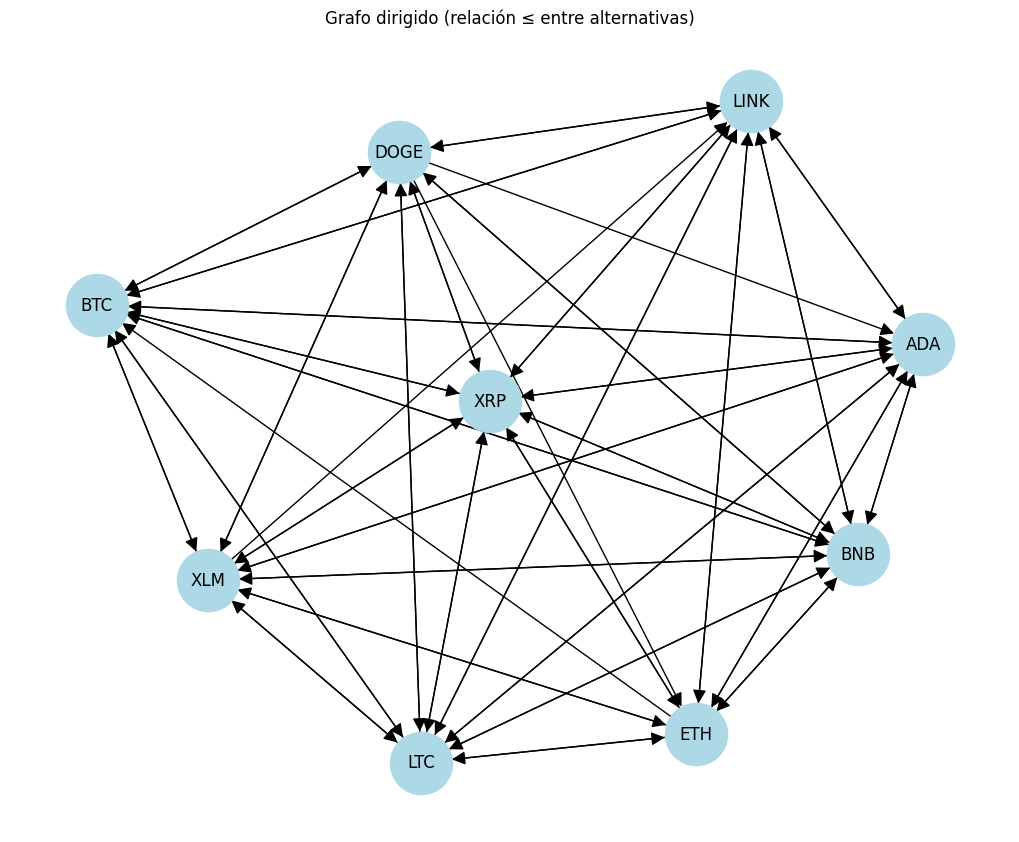

In [36]:
edges = []

for rr in results:
    # Acceder a los nombres de las alternativas comparadas
    alt_names = rr.alternatives

    # Acceder al ranking asignado por el modelo
    ranks = rr.rank_

    # Identificar cuál es mejor rankeado (menor número es mejor)
    if ranks[0] < ranks[1]:
        edges.append((alt_names[0], alt_names[1]))  # peor → mejor
    elif ranks[1] < ranks[0]:
        edges.append((alt_names[1], alt_names[0]))  # peor → mejor
    else: 
        # Nontrivial case. Insert heuristics. 
        # 1-2. Insert both (different order).
        # 3-4. Insert only one.
        # 5. Do not insert (could be disjointed) MAYBE IT WOULDN'T WORK
        edges.append((alt_names[0], alt_names[1]))
        edges.append((alt_names[1], alt_names[0]))

# TODO: Untie between ranking. Heuristics to break cycles. KEEP THE ORIGINAL GRAPH!!!!!!!!!!!!!!!!!!!!

# Crear grafo dirigido
G = nx.DiGraph()
G.add_edges_from(edges)

# Dibujar grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrowsize=20)
plt.title("Grafo dirigido (relación ≤ entre alternativas)")
plt.show()

In [38]:
#nx.recursive_simple_cycles(G)

In [39]:
def break_cycles_by_greedy_edge_removal(G):
    G = G.copy()
    while True:
        try:
            cycle = nx.find_cycle(G, orientation='original')
            # Remove one edge from the cycle (e.g., the first one)
            G.remove_edge(*cycle[-1][:2])
        except nx.exception.NetworkXNoCycle:
            break
    return G

In [40]:
new_G = break_cycles_by_greedy_edge_removal(G)
nx.recursive_simple_cycles(new_G)

[]

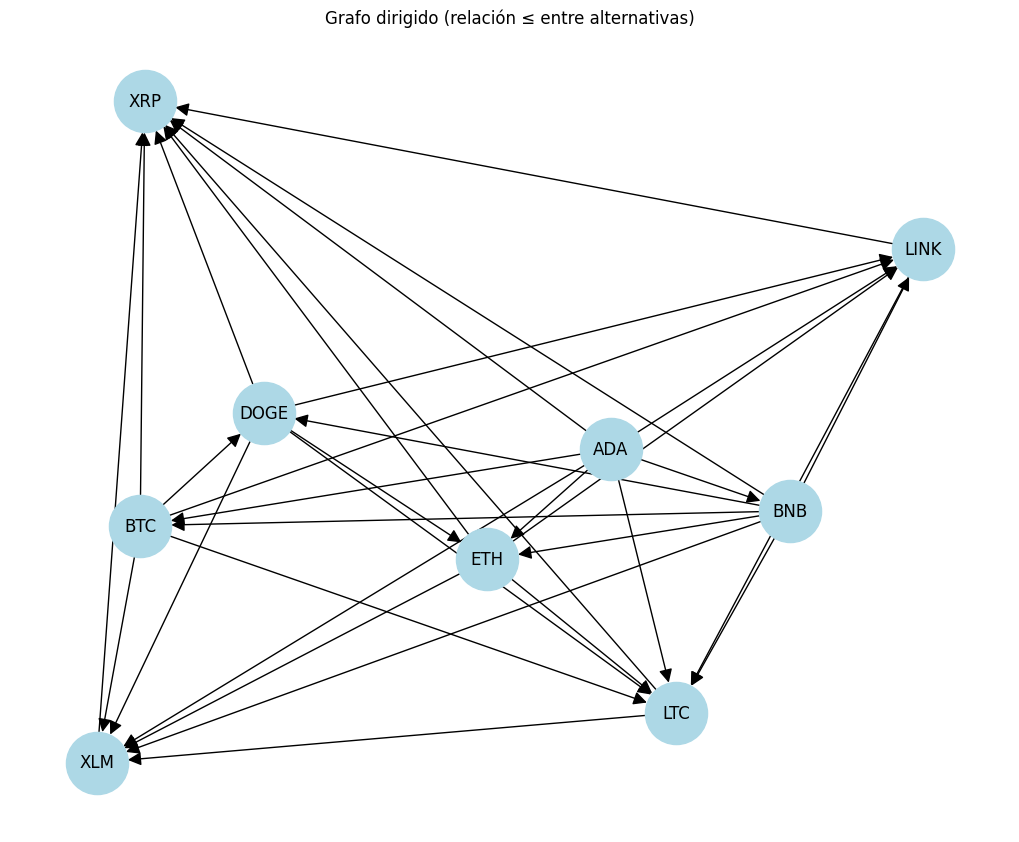

In [41]:
# Dibujar grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(new_G, seed=42)
nx.draw(new_G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrowsize=20)
plt.title("Grafo dirigido (relación ≤ entre alternativas)")
plt.show()

In [48]:
order = list(nx.topological_sort(new_G))

In [50]:
type(original_rank)

skcriteria.agg._agg_base.RankResult